# LAb5: Generalização de modelos lineares

<hr style="border:1px  solid black"> </hr>

### (Preencher)
## Nome: 
## Número: 

<hr style="border:1px  solid black"> </hr>

## Desenvolva e corra o código pedido nas células imediatamente abaixo das perguntas.

# IMPORTANTE:
## Uma vez completado, grave este Jupyter notebook com o seguinte nome:
## Axxxxx-Lab5.ipynb (Axxxxx: número de aluno)
##  e depois submeta o ficheiro no link do Moodle providenciado para o efeito.

<hr style="border:2px solid black"> </hr>

# Dados: $\texttt{breast_cancer}$ dataset do $\texttt{sklearn}$
### Considere os dados do $\texttt{breast_cancer}$ dataset do $\texttt{sklearn}$, divididos em três conjuntos, treino/validação/teste, segundo os comandos da próxima célula.
* ### X1a: dados de treino (array de $319\times30$)
* ### y1a: classe do dados de treino
* ### X1b: dados de validação (array de $100\times30$)
* ### y1b: classe do dados de validação
* ### X2: dados de treino (array de $150\times30$)
* ### y2: classe do dados de teste

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import  train_test_split
import sklearn.datasets as DT
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

D=DT.load_breast_cancer()
X=D.data
y=D.target

################################################################
#ATENÇÃO: Considerar os casos malígnos como positivos (classe 1)
#Necessário inverter classes
y=np.abs(y-1)
################################################################

#divitir em treino, validação e teste
X1,X2,y1,y2=train_test_split(X,y,test_size=150,stratify=y,random_state=42)
X1a,X1b,y1a,y1b=train_test_split(X1,y1,test_size=100,stratify=y1,random_state=42)

# Pergunta 1: Discriminantes logístico
##  Considere um discriminante logístico com regularização $\ell_1$ (lasso) e com os parâmetros $\texttt{C=2}$, $\texttt{solver='saga'}$ e $\texttt{max_iter=5000}$. Treine o classificador com os conjuntos de treino e validação (419 exemplos).
### a) Imprima o número total de erros e matriz de confusão (não normalizada) deste classificador para o conjunto de teste.
### b) Imprima o índice e os nomes (feature names) das dimensões dos dados que não interferem no processo de classificação (dimensões descartadas).
### c) Calibre este classificador de maneira a ter um número máximo de falsos negativos no teste inferior o igual a 5, e ao mesmo tempo mantendo o número total de erros igual à da alínea 1.a).
### d) Faça um plot da curva ROC deste classificador com os dados de teste. Inclua nesse plot o ponto operacional dos classificadores da alínea 1.a) e 1.c).

## 1.a)

In [60]:
lr=LogisticRegression(penalty='l1',solver='saga',C=2,max_iter=5000).fit(X1,y1)
y2e=lr.predict(X2)
print('Nº total de erros',np.sum(y2!=y2e))
print('Matriz de confusão:')
print(confusion_matrix(y2,y2e))

Nº total de erros 12
Matriz de confusão:
[[93  1]
 [11 45]]


## 1.b)

In [61]:
w=lr.coef_
w=w.squeeze()
idx=np.argwhere(w==0).squeeze()
fN=D.feature_names
print('Dimensões descartadas (total de %d):'%idx.shape[0])
for i in idx:
    print('%2d'%i,fN[i])

Dimensões descartadas (total de 11):
 4 mean smoothness
 9 mean fractal dimension
10 radius error
14 smoothness error
15 compactness error
16 concavity error
17 concave points error
18 symmetry error
19 fractal dimension error
24 worst smoothness
29 worst fractal dimension


## 1.c)

In [62]:
y2c=lr.decision_function(X2)
print(confusion_matrix(y2,y2c>-1.45))

[[87  7]
 [ 5 51]]


## 1.d)

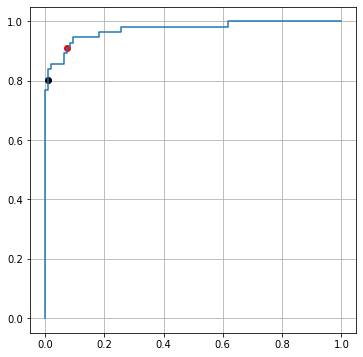

In [68]:
fpr,tpr,t=roc_curve(y2,y2c)

#Classificador 1
#fp-rate=FP/(FP+TN)
p11=1/(93+1)
#tp-rate=TP/(TP+FN)
p12=45/(45+11)

#Classificador 2
#fp-rate=FP/(FP+TN)
p21=7/(87+7)
#tp-rate=TP/(TP+FN)
p22=51/(5+51)

plt.figure(figsize=(6,6))
plt.plot(p11,p12,'ok')
plt.plot(p21,p22,'or')

plt.plot(fpr,tpr)
plt.axis('scaled')
plt.grid(True)



<hr style="border:2px solid black"> </hr>

# Pergunta 2 - SVMs:
## Considere o classificador da função $\texttt{SVC}$ com os parâmetros $\texttt{kernel='rbf'}$ e $\texttt{C=2}$.
### a) Faça um pré-processamento dos dados usando a função $\texttt{StandardScaler}$. Treine esta função com os dados treino e aplique a transformação aos três conjuntos (treino, validação e teste). Use os dados pré-processados nas alíneas seguintes.
### b) Pertende-se estimar o valor do parâmetro $\texttt{gamma}$  ($\gamma$) mais adequado para este problema. Para tal, use o conjunto de validação para achar o valor de $\gamma$ que resulta no menor número de erros (treine o $\texttt{SVC}$ com o conjunto de treino). Teste os seguintes valores de $\gamma$: $[0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175]$.
### c) Volte a treinar o classificador $\texttt{SVC}$ com os dados de treino e validação, e com o melhor valor de $\gamma$. Faça um plot da curva ROC deste classificador com os dados de teste. Inclua nesse plot o ponto operacional do classificadore. 
### d)  Calibre o classificador da alínea anterior de modo a obter zero (0) falsos negativos nos dados de teste. Após a calibração qual o número mínimo de falso positivos obtidos no teste?

## 2.a)

In [20]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler().fit(X1a)
X1an=sc.transform(X1a)
X1bn=sc.transform(X1b)
X2n=sc.transform(X2)


## 2.b)

In [48]:
#svm=SVC(kernel='rbf',C=2)
G=np.arange(0.0050,0.02,0.0025)
scoreTop=0
gBest=0
for g in G:
    svm=SVC(kernel='rbf',C=2,gamma=g).fit(X1an,y1a)
    score=svm.score(X1bn,y1b)
    if score>scoreTop:
        scoreTop=score
        gBest=g
print('Best Gamma:',gBest)
print('Best Score:',scoreTop)
print('Conjunto de validação - matriz de confusão')
print(confusion_matrix(y1b,svm.predict(X1bn)))

Best Gamma: 0.009999999999999998
Best Score: 0.99
Conjunto de validação - matriz de confusão
[[63  0]
 [ 2 35]]


## 2.c)

[[94  0]
 [ 2 54]]


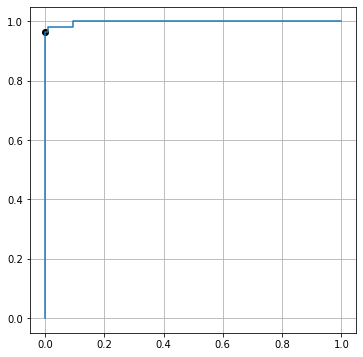

In [27]:
X1n=sc.transform(X1)
svm=SVC(kernel='rbf',C=2,gamma=0.01).fit(X1n,y1)
y2c=svm.decision_function(X2n)
fpr,tpr,t=roc_curve(y2,y2c)

print(confusion_matrix(y2,svm.predict(X2n)))

#fp-rate=FP/(FP+TN)
p1=0
#tp-rate=TP/(TP+FN)
p2=54/(2+54)

plt.figure(figsize=(6,6))
plt.plot(p1,p2,'ok')
plt.plot(fpr,tpr)
plt.axis('scaled')
plt.grid(True)



## 2.d)

In [43]:
print(confusion_matrix(y2,y2c>=-.9))
print('Número de falsos positivos = 10')

[[84 10]
 [ 0 56]]
Número de falsos positivos = 10
